In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
# sys.path.insert(1, '/content/drive/MyDrive/Annie/model/Xu')
# from supression_index_util import grating_summation_field
# from grating_util import makeGrating

Mounted at /content/drive


In [ ]:
#grating util

import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow, figure

def makeGaussian(size, radius=100, sharpness=3, center=None, annular=0, shift=0):
    """ 
    Make a square gaussian kernel.
    size is the length of a side of the square.
    inside radius, mask values are 1.
    outside the radius, there is a gaussian kernal with FWHM=sharpness.
    inside annular, it is reversed gaussian, i.e. decrease to 0. For annular 
    stimuli, i.e. donuts.
    """
    
    # assert radius > (sharpness/2)
    if radius < (sharpness/2):
        return np.zeros((size,size))
        
    assert annular < radius
    
    radius = radius - sharpness/2
    
    if annular > sharpness/2:
        annular = annular - sharpness/2
    
    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]
    
    if center is None:
        x0 = y0 = size // 2 + shift
    else:
        x0 = center[0]+shift
        y0 = center[1]+shift
    
    if sharpness != 0:
        outer_gaussian = np.exp(-4*np.log(2) * (np.clip((x-x0)**2 + (y-y0)**2 - radius**2,0,None)) / sharpness**2)
    else:
        outer_gaussian = np.heaviside(-(x-x0)**2 - (y-y0)**2 + radius**2, 0.5)
    
    if annular>0:
        if sharpness != 0:
            inner_gaussian = np.exp(-4*np.log(2) * (np.clip(-(x-x0)**2 - (y-y0)**2 + annular**2,0,None)) / sharpness**2)
        else:
            inner_gaussian = np.heaviside((x-x0)**2 + (y-y0)**2 - annular**2, 0.5)
        return inner_gaussian * outer_gaussian
    return outer_gaussian

def makeGrating(size, spatialf, ori=0, phase=0, imsize=224, sharpness=3, contrast=1, annular=0, dtype='uint8', shift=0, center=None):
    """
    Make a square grating.
    size: the full-width-half-maximum of gaussian mask
    which can be thought of as an effective radius.
    spatialf: spatial frequency.
    ori: orientation, 0 is horizental. 90 is vertical.
    phase: 0-360
    imsize: the image size.
    annular: inside diameter of the donut.
    sharpness: pixels of HMFW of gaussian mask.
    contrast: 0-1.
    """
    ori = ori/180*np.pi
    im = np.ones((imsize,imsize))
    # the last term is to make center phase 0.
    phi = (phase/np.pi*180-2*np.pi/spatialf*imsize/2)
    for x in range(imsize):
        for y in range(imsize):
            im[x,y] = np.sin(2*np.pi/spatialf*((x*np.cos(ori)+y*np.sin(ori))+phi))           
    gaussianmask = makeGaussian(imsize, size, sharpness, annular=annular, shift=shift, center=center)
    im = im*gaussianmask*contrast
    im = (im+1) / 2 * 255
    im = np.repeat(im[:,:,np.newaxis],3,axis=2)
    im = im.astype(dtype)
    return im
    

In [ ]:
# Cavanaugh et al., 2002: grating summation field, surround diameter, surround suppression index
# implementation, Xu Pan, 2021.

import numpy as np

def supression_index(dtc):
    # dtc: diameter tunning curve.
    max_index = np.argmax(dtc)
    max_r = np.max(dtc)
    suppress_r = np.min(dtc[max_index:])
    if max_r != 0:
        return 1-suppress_r/max_r
    else:
        return float("nan")

def grating_summation_field(dtc, d=None):
    # dtc: diameter tunning curve.
    # d: diameter list
    max_r = np.max(dtc)
    index = np.argmax(dtc > (0.95*max_r))
    if d is None:
        return index
    else:
        return d[index]

def surround_diameter(dtc, d=None):
    # dtc: diameter tunning curve.
    # d: diameter list
    max_r = np.max(dtc)
    index = np.argmax(dtc > ((max_r-dtc[-1])*0.05+dtc[-1]))
    if d is None:
        return index
    else:
        return d[index]

def supression_index_full_size(dtc):
    # compare peak and response at the end
    # dtc: diameter tunning curve.
    max_r = np.max(dtc)
    suppress_r = dtc[-1]
    return 1-suppress_r/max_r

def peak(dtc, d=None):
    # dtc: diameter tunning curve.
    # d: diameter list
    max_index = np.argmax(dtc)
    if d is None:
        return max_index
    else:
        return d[max_index]

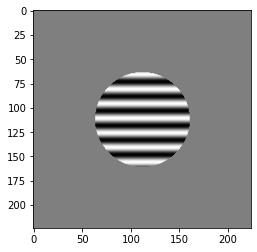

In [ ]:
imshow(makeGrating(50, 15, 0, 0))

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Annie/model/Copy of alexnet_allBN.h5')
# model = tf.keras.models.load_model('/home/xupan/Projects/FNM/imagenet_models/Keras_ResNet/results/weight/alexnet_allBN.h5')

# data_foler = '/home/xupan/Projects/Annie/results/'
data_foler = '/content/drive/MyDrive/Annie/model/Xu/results/'

receptive_field_size = {'activation':11, 'activation_1':51, 'activation_2':99,
                        'activation_3':131, 'activation_4':163}

mean = [103.939, 116.779, 123.68]
std = [58.393, 57.12, 57.375]

# layer = 'activation_1'
# neuron = 16
for layer in ['activation','activation_1','activation_2','activation_3','activation_4']:
    intermediate_activation = tf.keras.Model(inputs=model.input,
                                                  outputs=model.get_layer(layer).output)

    ctr_lyr = int(model.get_layer(layer).output_shape[1]/2)
    shift = int((224/model.get_layer(name=layer).output_shape[1])/2)
    
    for neuron in range(model.get_layer(layer).output_shape[3]):
        print(layer+': '+str(neuron))
        
        [sf, opti_ori] = np.load(data_foler+f"optimal_sti/{layer}/{neuron}_optsti.npy")
        [sizes, responses] = np.load(data_foler+f"diameter_tuning/dia_tuning_data/{layer}/{neuron}_dia_tuning.npy")

        gsf = grating_summation_field(responses, d=sizes)

#         if gsf+2 < receptive_field_size[layer]/2 and gsf>5:
        if gsf < receptive_field_size[layer]/2*0.9 and gsf > receptive_field_size[layer]/2*0.1 and gsf+2<receptive_field_size[layer]/2:
            # center orientation tuning curve
            ori_tuning = []
            for ori in range(0, 166, 15): # orientation
                activation = []
                for phi in range(0, 316, 45): # phase
                    im = makeGrating(gsf, sf, ori, phi, shift=shift)
                    im = np.asarray([(im[...,c]-mean[c])/std[c] for c in range(3)])
                    im = np.moveaxis(im,0,-1)
                    im = np.expand_dims(im,0)
                    activation_layer = intermediate_activation(im, training=False).numpy()
                    activation.append(activation_layer[0, ctr_lyr, ctr_lyr, neuron])
                ori_tuning.append(np.mean(np.asarray(activation)))
            ori_tuning = np.asarray(ori_tuning)
            ori_x = np.asarray([x for x in range(0, 166, 15)])
            max_ori = np.argmax(ori_tuning)
            
            # surround orientation tuning curve
            surround_ori_tuning = np.zeros((12,8))
            for j,surround_phi in enumerate(range(0, 316, 45)):
                for k,surround_ori in enumerate(range(0, 166, 15)):
                    surround_im = makeGrating(receptive_field_size[layer]/2, sf, surround_ori, surround_phi, shift=shift, annular=gsf+2)
                    surround_im = np.asarray([(surround_im[...,c]-mean[c])/std[c] for c in range(3)])
                    surround_im = np.moveaxis(surround_im,0,-1)
                    surround_im = np.expand_dims(surround_im,0)
                    activation_layer = intermediate_activation(surround_im, training=False).numpy()
                    surround_ori_tuning[k,j] = activation_layer[0, ctr_lyr, ctr_lyr, neuron]
            surround_ori_tuning = np.average(surround_ori_tuning, axis=1)

            # surround suppression orientation curve
            ori_suppression = np.zeros((12,8,8))
            for i,center_phi in enumerate(range(0, 316, 45)): # phase
                center_im = makeGrating(gsf, sf, ori_x[max_ori], center_phi, shift=shift)
                for j,surround_phi in enumerate(range(0, 316, 45)):
                    for k,surround_ori in enumerate(range(0, 166, 15)):
                        surround_im = makeGrating(receptive_field_size[layer]/2, sf, surround_ori, surround_phi, shift=shift, annular=gsf+2)
                        im = (center_im-(127))+(surround_im-(127))+127
                        im = np.asarray([(im[...,c]-mean[c])/std[c] for c in range(3)])
                        im = np.moveaxis(im,0,-1)
                        im = np.expand_dims(im,0)
                        activation_layer = intermediate_activation(im, training=False).numpy()
                        ori_suppression[k,i,j] = activation_layer[0, ctr_lyr, ctr_lyr, neuron]
            ori_suppression = np.average(ori_suppression, axis=(1,2))
            
            # surround suppression orientation curve with center is 15 degree away from optimal ori
            ori_suppression_15 = np.zeros((12,8,8))
            for i,center_phi in enumerate(range(0, 316, 45)): # phase
                center_im = makeGrating(gsf, sf, ori_x[max_ori]+15, center_phi, shift=shift)
                for j,surround_phi in enumerate(range(0, 316, 45)):
                    for k,surround_ori in enumerate(range(0, 166, 15)):
                        surround_im = makeGrating(receptive_field_size[layer]/2, sf, surround_ori, surround_phi, shift=shift, annular=gsf+2)
                        im = (center_im-(127))+(surround_im-(127))+127
                        im = np.asarray([(im[...,c]-mean[c])/std[c] for c in range(3)])
                        im = np.moveaxis(im,0,-1)
                        im = np.expand_dims(im,0)
                        activation_layer = intermediate_activation(im, training=False).numpy()
                        ori_suppression_15[k,i,j] = activation_layer[0, ctr_lyr, ctr_lyr, neuron]
            ori_suppression_15 = np.average(ori_suppression_15, axis=(1,2))
            
            # surround suppression orientation curve with center is 30 degree away from optimal ori
            ori_suppression_30 = np.zeros((12,8,8))
            for i,center_phi in enumerate(range(0, 316, 45)): # phase
                center_im = makeGrating(gsf, sf, ori_x[max_ori]+30, center_phi, shift=shift)
                for j,surround_phi in enumerate(range(0, 316, 45)):
                    for k,surround_ori in enumerate(range(0, 166, 15)):
                        surround_im = makeGrating(receptive_field_size[layer]/2, sf, surround_ori, surround_phi, shift=shift, annular=gsf+2)
                        im = (center_im-(127))+(surround_im-(127))+127
                        im = np.asarray([(im[...,c]-mean[c])/std[c] for c in range(3)])
                        im = np.moveaxis(im,0,-1)
                        im = np.expand_dims(im,0)
                        activation_layer = intermediate_activation(im, training=False).numpy()
                        ori_suppression_30[k,i,j] = activation_layer[0, ctr_lyr, ctr_lyr, neuron]
            ori_suppression_30 = np.average(ori_suppression_30, axis=(1,2))
            
            # surround suppression orientation curve with center is 45 degree away from optimal ori
            ori_suppression_45 = np.zeros((12,8,8))
            for i,center_phi in enumerate(range(0, 316, 45)): # phase
                center_im = makeGrating(gsf, sf, ori_x[max_ori]+45, center_phi, shift=shift)
                for j,surround_phi in enumerate(range(0, 316, 45)):
                    for k,surround_ori in enumerate(range(0, 166, 15)):
                        surround_im = makeGrating(receptive_field_size[layer]/2, sf, surround_ori, surround_phi, shift=shift, annular=gsf+2)
                        im = (center_im-(127))+(surround_im-(127))+127
                        im = np.asarray([(im[...,c]-mean[c])/std[c] for c in range(3)])
                        im = np.moveaxis(im,0,-1)
                        im = np.expand_dims(im,0)
                        activation_layer = intermediate_activation(im, training=False).numpy()
                        ori_suppression_45[k,i,j] = activation_layer[0, ctr_lyr, ctr_lyr, neuron]
            ori_suppression_45 = np.average(ori_suppression_45, axis=(1,2))
            
            # surround suppression orientation at (optori and optori+90) with center is low contrast
            ori_suppression_lowc = np.zeros((2,8,8))
            for i,center_phi in enumerate(range(0, 316, 45)): # phase
                center_im = makeGrating(gsf, sf, ori_x[max_ori], center_phi, shift=shift)
                for j,surround_phi in enumerate(range(0, 316, 45)):
                    for k,surround_ori in enumerate([ori_x[max_ori],ori_x[(max_ori+6)%12]]):
                        surround_im = makeGrating(receptive_field_size[layer]/2, sf, surround_ori, surround_phi, shift=shift, annular=gsf+2)
                        im = (center_im-(127))*0.13 + (surround_im-(127))+127
                        im = np.asarray([(im[...,c]-mean[c])/std[c] for c in range(3)])
                        im = np.moveaxis(im,0,-1)
                        im = np.expand_dims(im,0)
                        activation_layer = intermediate_activation(im, training=False).numpy()
                        ori_suppression_lowc[k,i,j] = activation_layer[0, ctr_lyr, ctr_lyr, neuron]
            ori_suppression_lowc = np.average(ori_suppression_lowc, axis=(1,2))
            ori_suppression_highc = np.asarray([ori_suppression[max_ori], ori_suppression[(max_ori+6)%12]])
            
            np.save(data_foler+f"direction_tuning_of_surround_suppression/data/{layer}/{neuron}_surround_suppression.npy",
                    np.asarray([ori_x, ori_tuning, ori_suppression, surround_ori_tuning, ori_suppression_15, ori_suppression_30, ori_suppression_45]))
            np.save(data_foler+f"direction_tuning_of_surround_suppression/data/{layer}/{neuron}_surround_suppression_high_low_c.npy", np.asarray([ori_suppression_highc, ori_suppression_lowc]))
            np.save(data_foler+f"direction_tuning_of_surround_suppression/data/{layer}/{neuron}_gsf.npy", np.asarray([gsf]))
            
            ori_tuning = np.concatenate((ori_tuning,ori_tuning,ori_tuning))
            ori_suppression = np.concatenate((ori_suppression,ori_suppression,ori_suppression))
            surround_ori_tuning = np.concatenate((surround_ori_tuning,surround_ori_tuning,surround_ori_tuning))
            ori_suppression_45 = np.concatenate((ori_suppression_45,ori_suppression_45,ori_suppression_45))
            
            plt.plot([x for x in range(-90, 91, 15)], ori_tuning[max_ori+6:max_ori+19], color='black')
            plt.plot([x for x in range(-90, 91, 15)], ori_suppression[max_ori+6:max_ori+19], color='black', linewidth=4)
            plt.plot([x for x in range(-90, 91, 15)], surround_ori_tuning[max_ori+6:max_ori+19], color='gray')
            plt.plot([x for x in range(-90, 91, 15)], ori_suppression_45[max_ori+6:max_ori+19], color='blue')
            plt.savefig(data_foler+f"direction_tuning_of_surround_suppression/plot/{layer}/{neuron}_dia_tuning.png", dpi=600)
            plt.clf()

OSError: ignored

574726144/574710816 [==============================] - 5s 0us/step
block3_conv1: 1


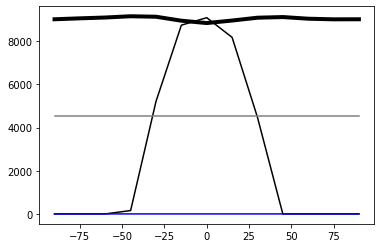

block3_conv1: 2


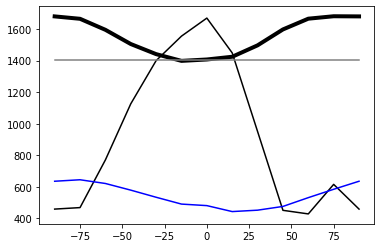

block3_conv1: 3
block3_conv1: 4


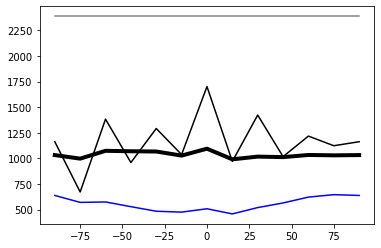

In [ ]:
layer = 'block3_conv1'

neurons = np.arange(1, 5)

vgg_model = tf.keras.applications.VGG19(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax'
)

intermediate_activation = tf.keras.Model(inputs=vgg_model.input,
                                                outputs=vgg_model.get_layer(layer).output)

data_foler = '/content/drive/MyDrive/model/VGG/results_70radius/'

receptive_field_size = {'block2_conv2':15, 'block3_conv1':27, 'block3_conv2':35,
                        'block3_conv3':43}

ctr_lyr = int(vgg_model.get_layer(layer).output_shape[1]/2)
shift = int((224/vgg_model.get_layer(name=layer).output_shape[1])/2)
    
for neuron in neurons:
  print(layer+': '+str(neuron))
        
  [sf, opti_ori] = np.load(data_foler+f"optimal_sti/{layer}/{neuron}_optsti.npy")
  [sizes, responses] = np.load(data_foler+f"diameter_tuning/dia_tuning_data/{layer}/{neuron}_dia_tuning.npy")

  gsf = grating_summation_field(responses, d=sizes)

#         if gsf+2 < receptive_field_size[layer]/2 and gsf>5:
  if gsf < receptive_field_size[layer]/2*0.9 and gsf > receptive_field_size[layer]/2*0.1 and gsf+2<receptive_field_size[layer]/2:
    # center orientation tuning curve
    ori_tuning = []
    for ori in range(0, 166, 15): # orientation
      activation = []
      for phi in range(0, 316, 45): # phase
        im = makeGrating(gsf, sf, ori, phi, shift=shift)
        inpt = np.expand_dims(im,0)
        inpt = tf.keras.applications.vgg19.preprocess_input(inpt)
        activation_layer = intermediate_activation(inpt, training=False).numpy()
        activation.append(activation_layer[0, ctr_lyr, ctr_lyr, neuron])
      ori_tuning.append(np.mean(np.asarray(activation)))
    ori_tuning = np.asarray(ori_tuning)
    ori_x = np.asarray([x for x in range(0, 166, 15)])
    max_ori = np.argmax(ori_tuning)
            
  # surround orientation tuning curve
    surround_ori_tuning = np.zeros((12,8))
    for j,surround_phi in enumerate(range(0, 316, 45)):
      for k,surround_ori in enumerate(range(0, 166, 15)):
        surround_im = makeGrating(receptive_field_size[layer]/2, sf, surround_ori, surround_phi, shift=shift, annular=gsf+2)
        inpt = np.expand_dims(im,0)
        inpt = tf.keras.applications.vgg19.preprocess_input(inpt)
        activation_layer = intermediate_activation(inpt, training=False).numpy()
        surround_ori_tuning[k,j] = activation_layer[0, ctr_lyr, ctr_lyr, neuron]
    surround_ori_tuning = np.average(surround_ori_tuning, axis=1)

    # surround suppression orientation curve
    ori_suppression = np.zeros((12,8,8))
    for i,center_phi in enumerate(range(0, 316, 45)): # phase
        center_im = makeGrating(gsf, sf, ori_x[max_ori], center_phi, shift=shift)
        for j,surround_phi in enumerate(range(0, 316, 45)):
          for k,surround_ori in enumerate(range(0, 166, 15)):
            surround_im = makeGrating(receptive_field_size[layer]/2, sf, surround_ori, surround_phi, shift=shift, annular=gsf+2)
            im = (center_im-(127))+(surround_im-(127))+127
            inpt = np.expand_dims(im,0)
            inpt = tf.keras.applications.vgg19.preprocess_input(inpt)
            activation_layer = intermediate_activation(inpt, training=False).numpy()
            ori_suppression[k,i,j] = activation_layer[0, ctr_lyr, ctr_lyr, neuron]
    ori_suppression = np.average(ori_suppression, axis=(1,2))
            
    # surround suppression orientation curve with center is 15 degree away from optimal ori
    ori_suppression_15 = np.zeros((12,8,8))
    for i,center_phi in enumerate(range(0, 316, 45)): # phase
      center_im = makeGrating(gsf, sf, ori_x[max_ori]+15, center_phi, shift=shift)
      for j,surround_phi in enumerate(range(0, 316, 45)):
        for k,surround_ori in enumerate(range(0, 166, 15)):
          surround_im = makeGrating(receptive_field_size[layer]/2, sf, surround_ori, surround_phi, shift=shift, annular=gsf+2)
          im = (center_im-(127))+(surround_im-(127))+127
          inpt = np.expand_dims(im,0)
          inpt = tf.keras.applications.vgg19.preprocess_input(inpt)
          activation_layer = intermediate_activation(inpt, training=False).numpy()
          ori_suppression_15[k,i,j] = activation_layer[0, ctr_lyr, ctr_lyr, neuron]
    ori_suppression_15 = np.average(ori_suppression_15, axis=(1,2))
            
    # surround suppression orientation curve with center is 30 degree away from optimal ori
    ori_suppression_30 = np.zeros((12,8,8))
    for i,center_phi in enumerate(range(0, 316, 45)): # phase
      center_im = makeGrating(gsf, sf, ori_x[max_ori]+30, center_phi, shift=shift)
      for j,surround_phi in enumerate(range(0, 316, 45)):
        for k,surround_ori in enumerate(range(0, 166, 15)):
          surround_im = makeGrating(receptive_field_size[layer]/2, sf, surround_ori, surround_phi, shift=shift, annular=gsf+2)
          im = (center_im-(127))+(surround_im-(127))+127
          inpt = np.expand_dims(im,0)
          inpt = tf.keras.applications.vgg19.preprocess_input(inpt)
          activation_layer = intermediate_activation(inpt, training=False).numpy()
          ori_suppression_30[k,i,j] = activation_layer[0, ctr_lyr, ctr_lyr, neuron]
    ori_suppression_30 = np.average(ori_suppression_30, axis=(1,2))
            
    # surround suppression orientation curve with center is 45 degree away from optimal ori
    ori_suppression_45 = np.zeros((12,8,8))
    for i,center_phi in enumerate(range(0, 316, 45)): # phase
      center_im = makeGrating(gsf, sf, ori_x[max_ori]+45, center_phi, shift=shift)
      for j,surround_phi in enumerate(range(0, 316, 45)):
        for k,surround_ori in enumerate(range(0, 166, 15)):
          surround_im = makeGrating(receptive_field_size[layer]/2, sf, surround_ori, surround_phi, shift=shift, annular=gsf+2)
          im = (center_im-(127))+(surround_im-(127))+127
          inpt = np.expand_dims(im,0)
          inpt = tf.keras.applications.vgg19.preprocess_input(inpt)
          activation_layer = intermediate_activation(inpt, training=False).numpy()
          ori_suppression_45[k,i,j] = activation_layer[0, ctr_lyr, ctr_lyr, neuron]
    ori_suppression_45 = np.average(ori_suppression_45, axis=(1,2))
            
    # surround suppression orientation at (optori and optori+90) with center is low contrast
    ori_suppression_lowc = np.zeros((2,8,8))
    for i,center_phi in enumerate(range(0, 316, 45)): # phase
      center_im = makeGrating(gsf, sf, ori_x[max_ori], center_phi, shift=shift)
      for j,surround_phi in enumerate(range(0, 316, 45)):
        for k,surround_ori in enumerate([ori_x[max_ori],ori_x[(max_ori+6)%12]]):
          surround_im = makeGrating(receptive_field_size[layer]/2, sf, surround_ori, surround_phi, shift=shift, annular=gsf+2)
          im = (center_im-(127))*0.13 + (surround_im-(127))+127
          inpt = np.expand_dims(im,0)
          inpt = tf.keras.applications.vgg19.preprocess_input(inpt)
          activation_layer = intermediate_activation(inpt, training=False).numpy()
          ori_suppression_lowc[k,i,j] = activation_layer[0, ctr_lyr, ctr_lyr, neuron]
    ori_suppression_lowc = np.average(ori_suppression_lowc, axis=(1,2))
    ori_suppression_highc = np.asarray([ori_suppression[max_ori], ori_suppression[(max_ori+6)%12]])
            
    # np.save(data_foler+f"direction_tuning_of_surround_suppression/data/{layer}/{neuron}_surround_suppression.npy",
    # np.asarray([ori_x, ori_tuning, ori_suppression, surround_ori_tuning, ori_suppression_15, ori_suppression_30, ori_suppression_45]))
    # np.save(data_foler+f"direction_tuning_of_surround_suppression/data/{layer}/{neuron}_surround_suppression_high_low_c.npy", np.asarray([ori_suppression_highc, ori_suppression_lowc]))
    # np.save(data_foler+f"direction_tuning_of_surround_suppression/data/{layer}/{neuron}_gsf.npy", np.asarray([gsf]))
            
    ori_tuning = np.concatenate((ori_tuning,ori_tuning,ori_tuning))
    ori_suppression = np.concatenate((ori_suppression,ori_suppression,ori_suppression))
    surround_ori_tuning = np.concatenate((surround_ori_tuning,surround_ori_tuning,surround_ori_tuning))
    ori_suppression_45 = np.concatenate((ori_suppression_45,ori_suppression_45,ori_suppression_45))
            
    plt.plot([x for x in range(-90, 91, 15)], ori_tuning[max_ori+6:max_ori+19], color='black')
    plt.plot([x for x in range(-90, 91, 15)], ori_suppression[max_ori+6:max_ori+19], color='black', linewidth=4)
    plt.plot([x for x in range(-90, 91, 15)], surround_ori_tuning[max_ori+6:max_ori+19], color='gray')
    plt.plot([x for x in range(-90, 91, 15)], ori_suppression_45[max_ori+6:max_ori+19], color='blue')
    plt.show()
    # plt.savefig(data_foler+f"direction_tuning_of_surround_suppression/plot/{layer}/{neuron}_dia_tuning.png", dpi=600)
    # plt.clf()